In this experiment you will use ping, traceroute and iperf.

###### Setup:  
-- Insert transceiver in intl0 (B).    
-- `rmmod ixgbe && modprobe ixgbe allow_unsupported_sfp=1` (Machine B)   
-- `ifconfig intl0 192.168.0.2` (Machine B)  
-- `ifconfig slf0 192.168.0.1` (Machine A)  
-- `ssh-add` (Machine A) #if it fails, run first: eval `ssh-agent -s`  
-- `mkdir /root/<crsid>` (Machine A, replace <crsid> with your crsid) 
  
-- `cd /root/<crsid>` (Machine A)  
-- `git clone http://github.com/cucl-srg/L50` (Machine A)  
-- `/root/L50/setup/mkdir1.sh <crsid>`. (Machine A)   
-- Connect slf0 (A) to intl0 (B)  
<img src="alt_setup1.jpg">  

In [1]:
crsid='jlf60' #your crsid
%run /root/$crsid/L50/Jupyter/useful/useful.py
%run /root/$crsid/L50/Jupyter/useful/useful1.py
%matplotlib inline
machB_ip = '128.232.82.64'
machA_ip = '128.232.82.63'# XXX REPLACE THIS WITH THE IP of the host 128.232.XXX.YYY
machB_ip_local = '192.168.0.2'
machA_ip_local = '192.168.0.1'

# 1. ping
ping is used to test the reachability of a host on an IP network. The source sends an ICMP Echo Request and the destination sends an ICMP Echo Reply. The round-trip time is measured.  
  
###### Usage:
  
`ping <address> [Optional: -c <count>] [Optional: -i <interval>] [Optional: -f]`  
interval = gap between pings in seconds, default=1  
-f = pings as fast as possible  
count = number of pings. If unspecified, ping runs until killed. 

### Experiment 1
Ping 1000 times. Plot the CDF of RTTs.

#### 1a A ping B

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine A to Machine B, 1000 times, interval 0.001 seconds.

In [6]:
ping_cmd = 'ping '+machB_ip_local+' -c 1000 -i 0.001'
for i in range(10):
    local_cmd(ping_cmd+' | grep -e "ttl" > /root/'+crsid+'/L50Lab1/1/exp1a_'+str(i))

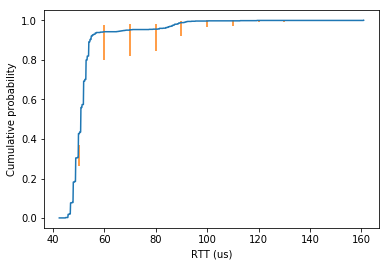

In [7]:
graph1('exp1a',crsid,10.0,1000)

#### 1b B ping A

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine B to Machine A, 1000 times, interval 0.001 seconds.

In [4]:
ping_cmd = 'ping '+machA_ip_local+' -c 1000 -i 0.001'
ssh = ssh_connect(machB_ip)
for i in range(10):
    with open('/root/'+crsid+'/L50Lab1/1/exp1b_'+str(i),'w+') as f:
        output = ssh_cmd(ping_cmd+' | grep -e "ttl"',ssh)
        f.write(output)
ssh.close()

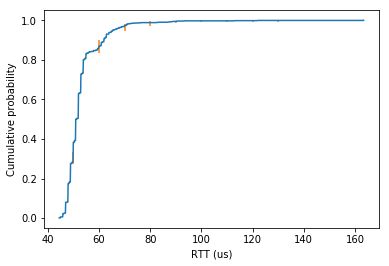

In [5]:
graph1('exp1b',crsid,10.0,1000)

### Experiment 2
Ping 500 times with varying intervals. Plot the CDFs of RTTs.

#### 2a A ping B

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine A to Machine B, 500 times for each interval.

In [16]:
interval=['0.000001', '0.00001', '0.0001','0.001','0.01','0.1']
for i in interval:
    ping_cmd = 'ping '+machB_ip_local+' -c 500 -i '+i
    local_cmd(ping_cmd+' | grep -e "ttl" > /root/'+crsid+'/L50Lab1/2/exp2a_'+i)

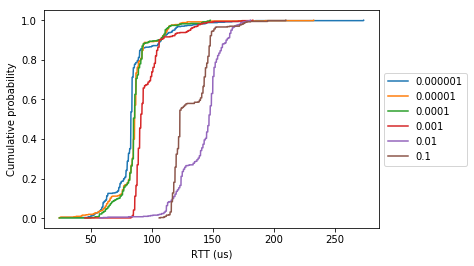

In [17]:
interval=['0.000001', '0.00001', '0.0001','0.001','0.01','0.1']
def graph2(exp,interval,num):
    for i in interval:
        rtt= getrtt('2/'+exp+'_'+i,crsid,num)
        values, base = np.histogram(rtt, bins=1000)
        cumulative = np.cumsum(values/float(num))
        plt.plot(base[:-1], cumulative, label=i)
    plt.ylabel("Cumulative probability")
    plt.xlabel("RTT (us)")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()
graph2('exp2a',interval,500)

#### 2b B ping A

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine B to Machine A, 500 times for each interval.

In [39]:
interval=['0.000001', '0.00001', '0.0001','0.001','0.01','0.1']
ssh = ssh_connect(machB_ip)
for i in interval:
    with open('/root/'+crsid+'/L50Lab1/2/exp2b_'+str(i),'w+') as f:
        ping_cmd = 'ping '+machA_ip_local+' -c 500 -i '+i
        output = ssh_cmd(ping_cmd+' | grep -e "ttl"',ssh)
        f.write(output)
ssh.close()

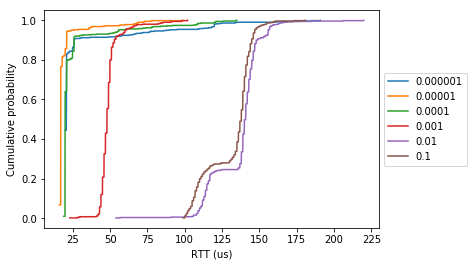

In [40]:
interval=['0.000001', '0.00001', '0.0001','0.001','0.01','0.1']
graph2('exp2b',interval,500)

### Experiment 3
Ping 10000 times using flooding.

#### 3a A ping B

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine A to Machine B 10000 times using flooding.

In [24]:
ping_cmd = 'ping '+machB_ip_local+' -c 1000 -f'
print local_cmd(ping_cmd + ' | grep -e "transmitted" -e "rtt"')

1000 packets transmitted, 1000 received, 0% packet loss, time 102ms
rtt min/avg/max/mdev = 0.025/0.085/0.184/0.014 ms, ipg/ewma 0.102/0.084 ms



#### 3b B ping A

<font color='red'>TODO:</font> Fill in `ping_cmd`, the command to ping from Machine B to Machine A 10000 times using flooding.

In [25]:
ssh = ssh_connect(machB_ip)
ping_cmd = 'ping '+machA_ip_local+' -c 1000 -f'
print ssh_cmd(ping_cmd+' | grep -e "transmitted" -e "rtt"', ssh)
ssh.close()

1000 packets transmitted, 1000 received, 0% packet loss, time 103ms
rtt min/avg/max/mdev = 0.062/0.092/0.210/0.013 ms, ipg/ewma 0.104/0.091 ms



### Experiment 4
Ping 10000 times using flooding, pinning to core 2.

taskset can be used to launch a command with a given CPU affinity. This means that the process will only run on the list of specified CPU cores.
###### Usage: 
`taskset -c <list of CPU cores> command [arguments]`    

#### A ping B

<font color='red'>TODO:</font> Fill in `cmd`, the command to ping from Machine A to Machine B 10000 times using flooding, pinning to core 2.

In [32]:
cmd = 'taskset -c 2 ping '+machB_ip_local+' -c 1000 -f'
print local_cmd(cmd+' | grep -e "transmitted" -e "rtt"')

1000 packets transmitted, 1000 received, 0% packet loss, time 123ms
rtt min/avg/max/mdev = 0.028/0.089/0.187/0.018 ms, ipg/ewma 0.123/0.096 ms



#### B ping A

<font color='red'>TODO:</font> Fill in `cmd`, the command to ping from Machine B to Machine A 10000 times using flooding, pinning to core 2.

In [29]:
cmd = 'taskset -c 2 ping '+machA_ip_local+' -c 1000 -f'
ssh = ssh_connect(machB_ip)
print ssh_cmd(cmd+' | grep -e "transmitted" -e "rtt"', ssh)
ssh.close()

1000 packets transmitted, 1000 received, 0% packet loss, time 129ms
rtt min/avg/max/mdev = 0.028/0.096/0.173/0.011 ms, ipg/ewma 0.129/0.095 ms



### Experiment 5
Ping 100 times for interval 0.001 and 0.000001, with varying rx-usecs. Plot the maximum, median and minimum RTTs for each rx-usecs value.

ethtool can be used to change interrupt rates for some NICs. rx-usecs is the number of microseconds to wait before raising an RX interrupt after a packet has been received. When rx-usecs is 0, rx-frames is used instead, the number of frames to queue up before raising an RX interrupt.   

#### 5a A ping B

<font color='red'>TODO:</font> Fill in `ping_cmd1`, the command to ping from Machine A to Machine B, 100 times, interval 0.001 seconds. Fill in `ping_cmd2`, the command to ping from Machine A to Machine B, 100 times, interval 0.000001 seconds.

In [51]:
usecs = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ssh = ssh_connect(machB_ip)
for u in usecs:
    for i in range(10):
        ssh_cmd("ethtool -C intl0 rx-usecs " + str(u), ssh) # set rx-usecs
        sleep(1)
        ping_cmd1 = 'ping '+machB_ip_local+' -c 100 -i 0.001'
        local_cmd(ping_cmd1+' | grep -e "ttl" > /root/'+crsid+'/L50Lab1/5/exp5a_0.001_'+str(u)+'_'+str(i))
        ping_cmd2 = 'ping '+machB_ip_local+' -c 100 -i 0.000001'
        local_cmd(ping_cmd2+' | grep -e "ttl" > /root/'+crsid+'/L50Lab1/5/exp5a_0.000001_'+str(u)+'_'+str(i))
ssh_cmd("ethtool -C intl0 rx-usecs 0", ssh)
ssh.close()

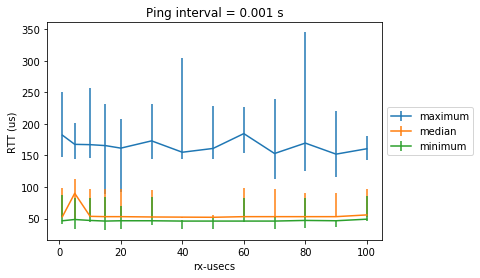

In [52]:
graph5_001('exp5a',crsid,usecs,100)

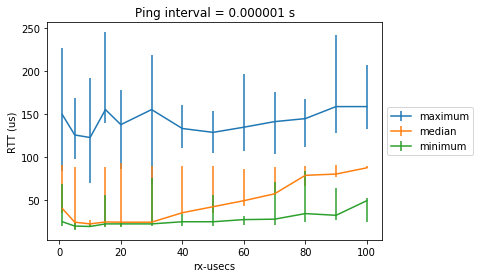

In [53]:
graph5_000001('exp5a',crsid,usecs,100)

#### 5b B ping A

<font color='red'>TODO:</font> Fill in `ping_cmd1`, the command to ping from Machine B to Machine A, 100 times, interval 0.001 seconds. Fill in `ping_cmd2`, the command to ping from Machine B to Machine A, 100 times, interval 0.000001 seconds.

In [48]:
usecs = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ssh = ssh_connect(machB_ip)
for u in usecs:
    for i in range(10):
        local_cmd("ethtool -C slf0 rx-usecs " + str(u)) # set rx-usecs
        with open('/root/'+crsid+'/L50Lab1/5/exp5b_0.001_'+str(u)+'_'+str(i),'w+') as f:
            ping_cmd1 = 'ping '+machA_ip_local+' -c 100 -i 0.001'
            output = ssh_cmd(ping_cmd1+' | grep -e "ttl"' ,ssh)
            f.write(output)
        with open('/root/'+crsid+'/L50Lab1/5/exp5b_0.000001_'+str(u)+'_'+str(i),'w+') as f:
            ping_cmd2 = 'ping '+machA_ip_local+' -c 100 -i 0.000001'
            output = ssh_cmd(ping_cmd2+' | grep -e "ttl"',ssh)
            f.write(output)
ssh.close()                
local_cmd("ethtool -C slf0 rx-usecs 0")

''

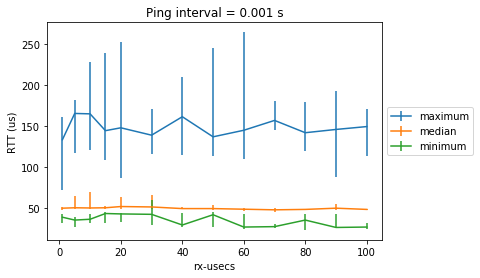

In [49]:
graph5_001('exp5b',crsid,usecs,100)

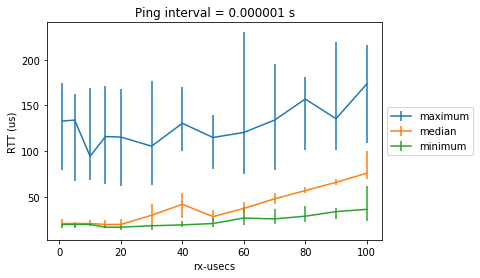

In [50]:
graph5_000001('exp5b',crsid,usecs,100)